In [1]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz

from keras.layers.core import Lambda
from keras import backend as K

def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)
    
    return BatchInd,NumBatches

import win32clipboard as clipboard
def toClipboardForExcel(array):
    """
    Copies an array into a string format acceptable by Exce~l.
    Columns separated by \t, rows separated by \n
    """
    # Create string from array
    line_strings = []
    for line in array:
        line_strings.append("\t".join(line.astype(str)).replace("\n",""))
    array_string = "\r\n".join(line_strings)

    # Put string into clipboard (open, clear, set, close)
    clipboard.OpenClipboard()
    clipboard.EmptyClipboard()
    clipboard.SetClipboardText(array_string)
    clipboard.CloseClipboard()
    
    
def Get_Feats_and_Targets(filename):
    import numpy as np
    
    def line_to_Feats(line):
        line = line.split(sep= ' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)
        
    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

Using TensorFlow backend.


In [2]:
[TrainInputs,TrainTargets] = Get_Feats_and_Targets('C:\Active Learning Work\GeoShapes\shapeset\shapeset1_1cspo_2_3.10000.train.amat')

[ValInputs,ValTargets] = Get_Feats_and_Targets('C:\Active Learning Work\GeoShapes\shapeset\shapeset1_1cspo_2_3.5000.valid.amat')

In [3]:
data_dim = TrainInputs.shape[-1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0.0005

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adagrad(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    
    return model
    
ISHard_model = Gen_Model(reg_coeff)

ISEasy_model = Gen_Model(reg_coeff)

Uni_model = Gen_Model(reg_coeff)

In [4]:
def acquisition_function_dist_to_threshold(model,samples,Num_Targets,Smoothing_Const=0):
    Output = model.predict(samples)
    Output -= 1/Num_Targets
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold) + Smoothing_Const
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold)
    return Sampling_Prob


def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[:,TargetLoop]
        Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
        ExpChange += Loss*ClassProb
    return ExpChange

def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    Sampling_Prob = ExpChange/np.sum(ExpChange)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

def Get_L2_Loss(Model,Coeff=0.01):
    Reg_Loss = 0
    Weights = Model.get_weights()
    NumWeights = len(Weights)
    for i in range(NumWeights):
        LayerWeights = Weights[i]
        LayerWeights_Sq = LayerWeights**2
        Reg_Loss += LayerWeights_Sq.sum()
    Reg_Loss*=Coeff
    return Reg_Loss


def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    ExpChange = ExpChange/np.sum(ExpChange)
    
    if Rescale == 1:
        Median_Prob = np.median(ExpChange)
        Min_Prob = np.min(ExpChange)
        ExpChange[ExpChange > Median_Prob] += Min_Prob/2
        ExpChange[ExpChange < Median_Prob] -= Min_Prob/2
    return ExpChange


def ablate_network(model,ablation_perc):
    weights = model.get_weights()
    save_weights = weights.copy()
    NumLayers = len(weights)
    total_numweights  = 0 
    for i in range(NumLayers):
        layer = weights[i]
        total_numweights += len(layer.flatten())
    num_ablations = np.int(ablation_perc*total_numweights)
    weights = ablate_weights(weights,num_ablations)
    model.set_weights(weights)
        
    return(model,save_weights)


def ablation_curve(model,num_tests,max_perc,inputs,targets):
    Perc_Space = np.linspace(0,max_perc,num_tests)
    Performance = np.zeros(num_tests)
    for i in range(num_tests):
        model,save_weights = ablate_network(model,Perc_Space[i])
        Perf = model.test_on_batch(inputs,targets)
        Performance[i] = Perf[1]
        model.set_weights(save_weights)
        
        AUC = trapz(Performance,Perc_Space)
        
    return AUC,Performance
    
    
def ablate_weights(weights,num_ablations):
    NumLayers = len(weights)
    LayerShape = []
    LayerShape = []
    LayerNodes = [0]
    FlattenedNodes = np.empty([0])
    for i in range(NumLayers):
        LayerShape.append(weights[i].shape)
        LayerNodes.append(len(weights[i].flatten()))
        FlattenedNodes = np.append(FlattenedNodes,weights[i].flatten())
        Index = np.linspace(0,len(FlattenedNodes)-1,num=len(FlattenedNodes),dtype = int)
    RandChoice = np.random.choice(Index,size = num_ablations,replace=False)
    FlattenedNodes[RandChoice] = 0
    FirstInd = 0
    for i in range(NumLayers):
        FirstInd += LayerNodes[i]
        SecondInd = FirstInd + LayerNodes[i+1]
        Sample = FlattenedNodes[FirstInd:SecondInd]
        Sample = Sample.reshape(LayerShape[i])
        weights[i] = Sample
        
    return weights


def acquisition_function_ablation(model,Inputs,Targets,Cluster_Size):
    BatchInd,NumBatches = mini_batches(Inputs,Cluster_Size)
    AUC_Record = np.zeros([Inputs.shape[0]])
    count= 0
    for Batch in BatchInd:
        if Batch.shape[0] != 0:
            BatchInputs = Inputs[Batch,:]
            BatchTargets = Targets[Batch,:]
            SaveWeights = model.get_weights()
            Hard_model.fit(BatchInputs,BatchTargets,batch_size=64,verbose=0)
            AUC,_ = ablation_curve(model,30,1,Inputs,Targets)
            AUC_Record[Batch] = AUC.copy()
            Hard_model.set_weights(SaveWeights)
            count +=1
        
    Sampling_Prob = AUC_Record/AUC_Record.sum()
    return Sampling_Prob
    
    


In [5]:
count = 0 
Num_Epochs = 300
Num_BurnIn = 1
Batch_Size = 64

Smoothing_Constant = 0

<IPython.core.display.Javascript object>


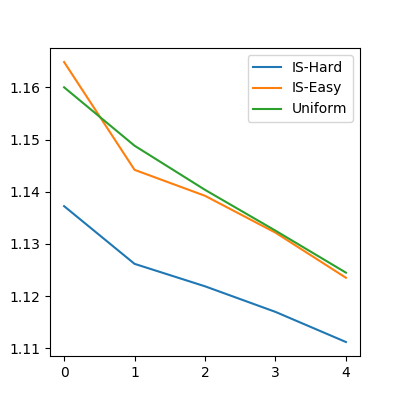

<IPython.core.display.Javascript object>


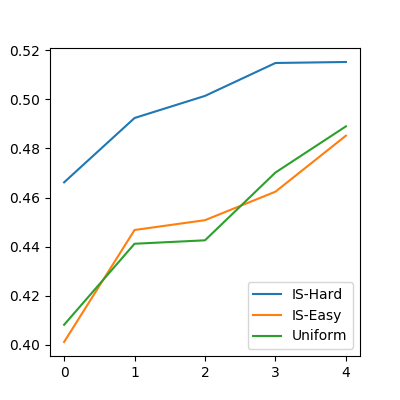

0
1
2
3
4
5


KeyboardInterrupt: 

In [7]:
Val_Error = np.zeros([Num_Epochs,3])
Val_Acc = np.zeros([Num_Epochs,3])

fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()


def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
            
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
        ISHard_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        ISEasy_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]

        Uni_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
    else:
        Hard_Sampling_Probability = acquisition_function_dist_to_threshold(ISHard_model,TrainInputs,Num_Targets,0)
        Easy_SamplingProbability = 1/acquisition_function_exp_model_change(ISEasy_model,TrainInputs,Num_Targets,0)
        Easy_SamplingProbability = Easy_SamplingProbability/Easy_SamplingProbability.sum()
        
        ISHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Hard_Sampling_Probability,1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        ISEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Easy_SamplingProbability,1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/NumSamples*np.ones(NumSamples)),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]

    print(EpochLoop)
    
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='IS-Hard')
    ax.plot(Val_Error[0:count,1],label='IS-Easy')
    ax.plot(Val_Error[0:count,2],label='Uniform')
    ax.legend()
    fig.canvas.draw()
    
    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='IS-Hard')
    ax2.plot(Val_Acc[0:count,1],label='IS-Easy')
    ax2.plot(Val_Acc[0:count,2],label='Uniform')
    ax2.legend()
    fig2.canvas.draw()
    
    count += 1

In [9]:
[TestInputs,TestTargets] = Get_Feats_and_Targets('C:\Active Learning Work\GeoShapes\shapeset\shapeset1_1cspo_2_3.5000.test.amat')

In [10]:
TestError = np.zeros([7,2])
TestError[0,:] = UniHard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = UniEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = Uni_model.test_on_batch(TestInputs,TestTargets)

In [11]:
toClipboardForExcel(TestError)